<a href="https://colab.research.google.com/github/eraj256/Datascience_project-/blob/main/fakereal_newz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [5]:
# Load Fake and Real datasets
fake = pd.read_csv("/content/Fake.csv")
real = pd.read_csv("/content/True.csv")

# Add labels
fake["label"] = "FAKE"
real["label"] = "REAL"

In [6]:
# Merge datasets
data = pd.concat([fake, real], axis=0).reset_index(drop=True)
print(data.head())
print(data["label"].value_counts())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date label  
0  December 31, 2017  FAKE  
1  December 31, 2017  FAKE  
2  December 30, 2017  FAKE  
3  December 29, 2017  FAKE  
4  December 25, 2017  FAKE  
label
FAKE    23481
REAL    21417
Name: count, dtype: int64


In [8]:
data.shape

(44898, 5)

In [9]:
data.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [10]:
data.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [36]:
# Check duplicates based on 'text'
duplicates = data.duplicated(subset="text").sum()
print(f"Number of duplicate articles: {duplicates}")

Number of duplicate articles: 6252


In [37]:
# Remove duplicates
data = data.drop_duplicates(subset="text").reset_index(drop=True)
print(f"Dataset shape after removing duplicates: {data.shape}")

Dataset shape after removing duplicates: (38646, 5)


## Exploratory Data Analysis (EDA)

/tmp/ipython-input-66278107.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=data, palette="coolwarm")


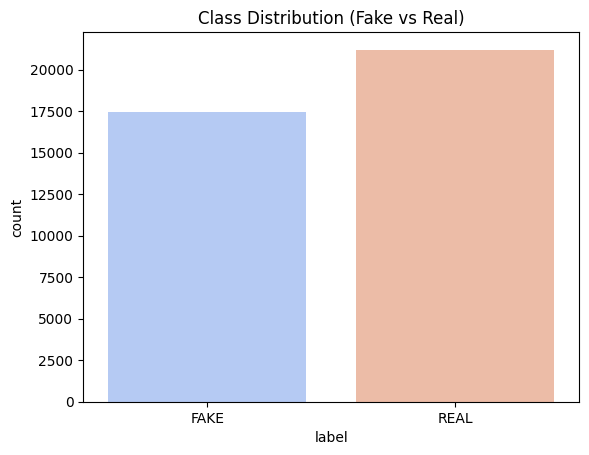

In [38]:
# Class distribution
sns.countplot(x="label", data=data, palette="coolwarm")
plt.title("Class Distribution (Fake vs Real)")
plt.show()

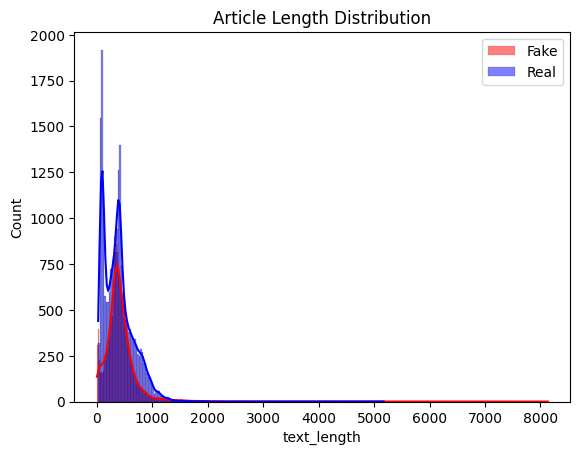

In [39]:
# Article length distribution
data["text_length"] = data["text"].apply(lambda x: len(str(x).split()))
sns.histplot(data[data["label"]=="FAKE"]["text_length"], color="red", label="Fake", kde=True)
sns.histplot(data[data["label"]=="REAL"]["text_length"], color="blue", label="Real", kde=True)
plt.legend()
plt.title("Article Length Distribution")
plt.show()

## Preprocessing & Feature Engineering (TF-IDF)

In [11]:
# Features and Labels
X = data["text"]
y = data["label"].map({"FAKE":0, "REAL":1})


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Model Training & Evaluation

In [16]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
}

results = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nModel: {name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
    results[name] = acc


Model: Logistic Regression
Accuracy: 0.9846325167037862
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4733
           1       0.98      0.99      0.98      4247

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980


Model: Naive Bayes
Accuracy: 0.9327394209354121
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      4733
           1       0.93      0.92      0.93      4247

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980



## Confusion Matrix & ROC Curve

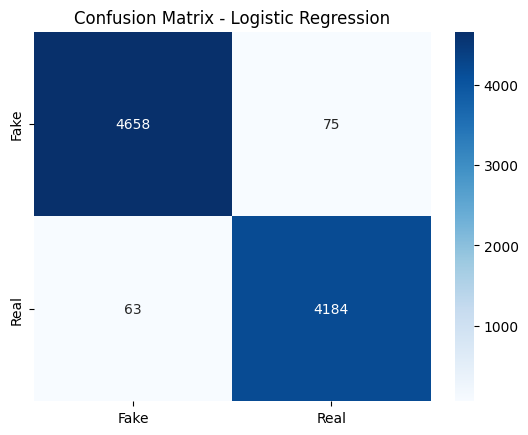

In [15]:
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train_tfidf, y_train)
y_pred = best_model.predict(X_test_tfidf)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

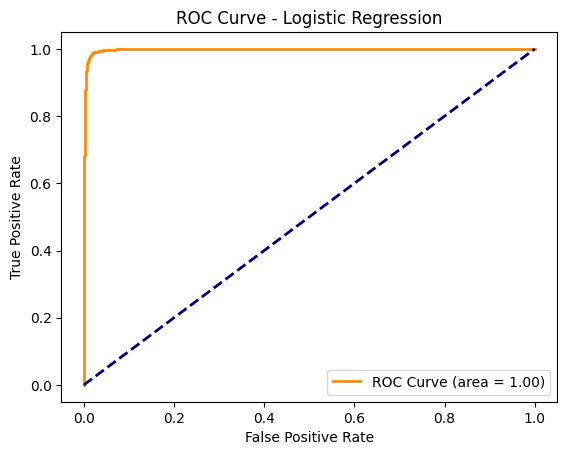

In [54]:
# ROC Curve
y_prob = best_model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

# CROSS CHECK NEWS IS FAKE OR REAL:

In [18]:
# Example new article
new_article = ["Trump calls on EU to pressure Putin with 100% tariffs on China and India"]

# Transform using the SAME vectorizer
new_article_tfidf = vectorizer.transform(new_article)

# Predict
prediction = best_model.predict(new_article_tfidf)
proba = best_model.predict_proba(new_article_tfidf)

print("Prediction:", "REAL" if prediction[0] == 1 else "FAKE")
print("Probability (Fake vs Real):", proba)


Prediction: REAL
Probability (Fake vs Real): [[0.46040747 0.53959253]]


In [21]:
# Example new article
new_article = ["Breaking: Scientists confirm that drinking two bottles of cola every morning cures cancer completely within a week."]

# Transform using the SAME vectorizer
new_article_tfidf = vectorizer.transform(new_article)

# Predict
prediction = best_model.predict(new_article_tfidf)
proba = best_model.predict_proba(new_article_tfidf)

print("Prediction:", "REAL" if prediction[0] == 1 else "FAKE")
print("Probability (Fake vs Real):", proba)


Prediction: REAL
Probability (Fake vs Real): [[0.44539659 0.55460341]]
